# Visualize keyPoints

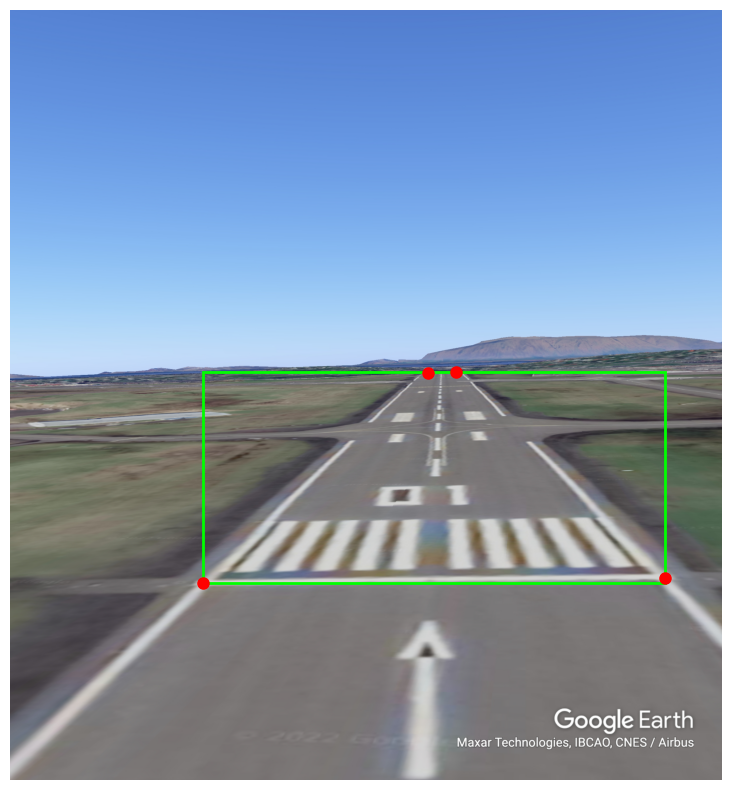

In [1]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

image_path = "/home/aws_install/data/yolonas_pose_base/images/train/BIRK_01_500_461.jpeg"
label_path = "/home/aws_install/data/yolonas_pose_base/labels/train/BIRK_01_500_461.txt"  # ton fichier txt

image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image non trouvée : {image_path}")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

H, W, _ = image.shape


with open(label_path, "r") as f:
    line = f.readline().strip()
parts = line.split()

# class, x_center_norm, y_center_norm, width_norm, height_norm
cls = parts[0]
x_center = float(parts[1])
y_center = float(parts[2])
w_box = float(parts[3])
h_box = float(parts[4])

x_min = int((x_center - w_box/2) * W)
x_max = int((x_center + w_box/2) * W)
y_min = int((y_center - h_box/2) * H)
y_max = int((y_center + h_box/2) * H)

# 4: (x, y, visibility) 
keypoints = []
for i in range(5, len(parts), 3):
    x_kp = float(parts[i]) * W
    y_kp = float(parts[i+1]) * H
    visibility = parts[i+2]  # peut être utilisé ou non
    keypoints.append((x_kp, y_kp))

plt.figure(figsize=(12, 10))
plt.imshow(image_rgb)
plt.axis("off")

rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                     edgecolor='lime', facecolor='none', linewidth=2)
plt.gca().add_patch(rect)

for (x, y) in keypoints:
    plt.plot(x, y, 'ro', markersize=8)

plt.show()


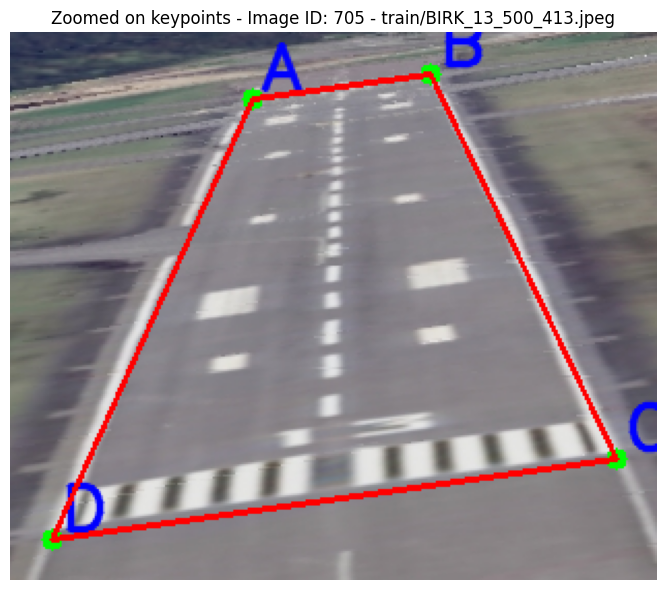

In [1]:
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# === Paths ===
json_path = Path("/home/aws_install/data/yolonas_pose_base/annotations/yolonas_pose_annotations.json")
image_base = Path("/home/aws_install/data/yolonas_pose_base/images")

# === Load annotation JSON ===
with open(json_path, "r") as f:
    data = json.load(f)

# === User-defined image ID to visualize ===
TARGET_IMAGE_ID = 705  # ← Change this to the ID you want

# === Build quick lookup maps ===
images = {img["id"]: img for img in data["images"]}
annotations_by_image = {}
for ann in data["annotations"]:
    annotations_by_image.setdefault(ann["image_id"], []).append(ann)

# === Grab image info ===
if TARGET_IMAGE_ID not in images:
    print(f"❌ Image ID {TARGET_IMAGE_ID} not found.")
    exit()

img_info = images[TARGET_IMAGE_ID]
img_path = image_base / img_info["file_name"]
img = cv2.imread(str(img_path))
if img is None:
    print(f"❌ Couldn't load image: {img_path}")
    exit()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
skeleton = data["categories"][0]["skeleton"]
keypoints_list = data["categories"][0]["keypoints"]
annotations = annotations_by_image.get(TARGET_IMAGE_ID, [])

# === Collect all visible keypoints coordinates to compute bounding box ===
all_points = []

for ann in annotations:
    keypoints = ann["keypoints"]
    points = []

    for i in range(0, len(keypoints), 3):
        x, y, v = keypoints[i], keypoints[i + 1], keypoints[i + 2]
        if v > 0:
            points.append((int(x), int(y)))
            all_points.append((int(x), int(y)))
        else:
            points.append(None)

# === If there are no visible keypoints, show full image ===
if len(all_points) == 0:
    print("⚠️ No visible keypoints found, displaying full image.")
    img_crop = img
else:
    # Compute bounding box around all visible keypoints
    xs, ys = zip(*all_points)
    x_min, x_max = max(min(xs) - 20, 0), min(max(xs) + 20, img.shape[1])  # padding 20 px
    y_min, y_max = max(min(ys) - 20, 0), min(max(ys) + 20, img.shape[0])  # padding 20 px

    # Crop the image
    img_crop = img[y_min:y_max, x_min:x_max]

    # Adjust keypoint coordinates relative to cropped image for drawing
    for ann in annotations:
        keypoints = ann["keypoints"]
        for i in range(0, len(keypoints), 3):
            x, y, v = keypoints[i], keypoints[i + 1], keypoints[i + 2]
            if v > 0:
                keypoints[i] = x - x_min
                keypoints[i + 1] = y - y_min

# === Draw annotations on cropped image ===
for ann in annotations:
    keypoints = ann["keypoints"]
    points = []

    for i in range(0, len(keypoints), 3):
        x, y, v = keypoints[i], keypoints[i + 1], keypoints[i + 2]
        kp_name = keypoints_list[i // 3]

        if v > 0:
            coord = (int(x), int(y))
            cv2.circle(img_crop, coord, 5, (0, 255, 0), -1)
            cv2.putText(
                img_crop,
                kp_name,
                (coord[0] + 5, coord[1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.0,
                (0, 0, 255),
                2,
                cv2.LINE_AA
            )
            points.append(coord)
        else:
            points.append(None)

    for kp1, kp2 in skeleton:
        if points[kp1] and points[kp2]:
            cv2.line(img_crop, points[kp1], points[kp2], (255, 0, 0), 2)

# === Show cropped image ===
plt.figure(figsize=(8, 6))
plt.imshow(img_crop)
plt.title(f"Zoomed on keypoints - Image ID: {TARGET_IMAGE_ID} - {img_info['file_name']}")
plt.axis("off")
plt.tight_layout()
plt.show()
